In [69]:
import pandas as pd
import numpy as np 
from sklearn.datasets import fetch_openml

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

#### Get the data 

In [71]:
data = fetch_openml("adult", as_frame=True)

df = data.data  
df["income"] = data.target

df = pd.concat([df, df.sample(10, random_state=42)], ignore_index=True)

print(df.duplicated().sum()), print(df.shape) 

197
(48852, 15)


C:\Users\OMAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\datasets\_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=179
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=1590

  warn(warning_msg)


(None, None)

#### Check NA %

In [72]:
df.isna().sum()/df.shape[0]*100

age               0.000000
workclass         5.729550
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        5.750020
relationship      0.000000
race              0.000000
sex               0.000000
capitalgain       0.000000
capitalloss       0.000000
hoursperweek      0.000000
native-country    1.754278
income            0.000000
dtype: float64

In [73]:
df[df['workclass'].isna()]['occupation'].isna().sum()/df.shape[0]*100

5.72955047899779

#### Check if NA happening together

In [74]:
df[df['workclass'].isna()][['workclass', 'occupation']]

,workclass,occupation
27,NaN,NaN
61,NaN,NaN
69,NaN,NaN
77,NaN,NaN
106,NaN,NaN
...,...,...
48682,NaN,NaN
48769,NaN,NaN
48800,NaN,NaN
48812,NaN,NaN


In [75]:
df['workclass'].value_counts()

workclass
Private             33915
Self-emp-not-inc     3862
Local-gov            3137
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

#### Remove rows with NA

In [76]:
df_process = df.copy()

df_process = df_process.dropna(subset=['occupation', 'native-country'])
print(df.shape, df_process.shape)
print(df_process.info())

(48852, 15) (45232, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 45232 entries, 0 to 48851
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45232 non-null  category
 1   workclass       45232 non-null  category
 2   fnlwgt          45232 non-null  int64   
 3   education       45232 non-null  category
 4   education-num   45232 non-null  int64   
 5   marital-status  45232 non-null  category
 6   occupation      45232 non-null  category
 7   relationship    45232 non-null  category
 8   race            45232 non-null  category
 9   sex             45232 non-null  category
 10  capitalgain     45232 non-null  category
 11  capitalloss     45232 non-null  category
 12  hoursperweek    45232 non-null  category
 13  native-country  45232 non-null  category
 14  income          45232 non-null  category
dtypes: category(13), int64(2)
memory usage: 1.6 MB
None


#### Update columns types

In [77]:
df_process[["capitalgain", "capitalloss", "hoursperweek", "age"]] = df_process[["capitalgain", "capitalloss", "hoursperweek", "age"]].astype(int)
df_process.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45232 entries, 0 to 48851
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45232 non-null  int32   
 1   workclass       45232 non-null  category
 2   fnlwgt          45232 non-null  int64   
 3   education       45232 non-null  category
 4   education-num   45232 non-null  int64   
 5   marital-status  45232 non-null  category
 6   occupation      45232 non-null  category
 7   relationship    45232 non-null  category
 8   race            45232 non-null  category
 9   sex             45232 non-null  category
 10  capitalgain     45232 non-null  int32   
 11  capitalloss     45232 non-null  int32   
 12  hoursperweek    45232 non-null  int32   
 13  native-country  45232 non-null  category
 14  income          45232 non-null  category
dtypes: category(9), int32(4), int64(2)
memory usage: 2.1 MB


#### Check if education-num is enough

In [78]:
## educational number could replace education 

df_process.value_counts(subset=["education", "education-num"]).reset_index(name="count").sort_values(by="education-num", ascending=True)

,education,education-num,count
15,Preschool,1,72
14,1st-4th,2,222
13,5th-6th,3,449
8,7th-8th,4,823
10,9th,5,676
7,10th,6,1223
5,11th,7,1620
11,12th,8,578
0,HS-grad,9,14788
1,Some-college,10,9900


In [79]:
df_process.drop_duplicates().reset_index() #198
df_process = df_process.drop(columns=["education"])

df_process.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,income
0,2,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


#### Map the target

In [80]:
## target transform 

df_process["income"] = df_process["income"].map({">50K": 1, "<=50K": 0})
df_process["income"].value_counts()


income
0    34024
1    11208
Name: count, dtype: int64

#### Split the data

In [81]:
data = df_process.drop(columns=['income'])


In [82]:
X_train, X_temp, y_train, y_temp = train_test_split(data, df_process['income'], test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(X_train.shape[0]/data.shape[0]*100, X_valid.shape[0]/data.shape[0]*100, X_test.shape[0]/data.shape[0]*100)

69.9991156703219 15.00044216483905 15.00044216483905


In [83]:
X_train

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,101603,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,2,United-States
1,3,Local-gov,145290,3,Married-civ-spouse,Other-service,Husband,White,Male,0,0,2,United-States
2,1,Private,339482,2,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,2,Mexico
3,2,Federal-gov,403489,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,2,United-States
4,1,Private,181838,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,3,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31657,1,Private,34393,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,2,United-States
31658,0,Private,542762,13,Never-married,Sales,Other-relative,Black,Male,0,0,3,United-States
31659,1,Private,157568,10,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,2,United-States
31660,2,Private,176900,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,4,United-States


#### Cat Handelling 

In [84]:
categorical_columns = data.select_dtypes(include=['category', 'object']).columns
categorical_columns

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'native-country'],
      dtype='object')

In [86]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown="infrequent_if_exist", min_frequency=2)

encoded_train  = encoder.fit_transform(X_train[categorical_columns])
encoded_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
X_train = pd.concat([X_train.drop(columns=categorical_columns), encoded_df], axis=1)

encoded_valid  = encoder.transform(X_valid[categorical_columns])
encoded_df = pd.DataFrame(encoded_valid, columns=encoder.get_feature_names_out(categorical_columns))
X_valid = pd.concat([X_valid.drop(columns=categorical_columns), encoded_df], axis=1)

encoded_test  = encoder.transform(X_test[categorical_columns])
encoded_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))
X_test = pd.concat([X_test.drop(columns=categorical_columns), encoded_df], axis=1)

X_train.head()

C:\Users\OMAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,age,fnlwgt,education-num,capitalgain,capitalloss,hoursperweek,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,2,101603,13,0,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,145290,3,0,0,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,339482,2,0,0,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,403489,14,0,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,181838,9,0,0,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Logisitic Regression

##### Predict

In [96]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
y_test_pred = clf.predict(X_test)

y_train_prop = clf.predict_proba(X_train)
y_valid_prop = clf.predict_proba(X_valid)
y_test_prop = clf.predict_proba(X_test)

print(len(y_train_pred), len(y_valid_pred), len(y_test_pred))

31662 6785 6785


C:\Users\OMAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Eval

In [101]:
def calculate_metrics(y_true, y_pred, y_prob):

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    return {"Precision": precision, "Recall": recall, "AUC-ROC": auc_roc}

In [106]:
calculate_metrics(y_valid, y_valid_pred, y_valid_prop[:, 1])

{'Precision': 0.6937581274382315,
 'Recall': 0.6196283391405343,
 'AUC-ROC': 0.8860403056218706}

In [107]:
calculate_metrics(y_test, y_test_pred, y_test_prop[:, 1])

{'Precision': 0.6972833117723156,
 'Recall': 0.6359882005899705,
 'AUC-ROC': 0.8860550214139588}

#### XGBoost

In [109]:
df_process.shape

(45232, 14)

In [121]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',  # Evaluation metric (log loss)
    'max_depth': 3,  # Tree depth
    'learning_rate': 0.1,  # Step size
    'n_estimators': 1000
}

evallist = [(dtrain, 'train'), (dvalid, 'eval'), (dtest, 'test')]

bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=10)

[0]	train-logloss:0.52682	eval-logloss:0.53368	test-logloss:0.52968
[1]	train-logloss:0.50178	eval-logloss:0.50808	test-logloss:0.50440
[2]	train-logloss:0.48115	eval-logloss:0.48674	test-logloss:0.48334
[3]	train-logloss:0.46410	eval-logloss:0.46899	test-logloss:0.46567
[4]	train-logloss:0.44944	eval-logloss:0.45419	test-logloss:0.45106
[5]	train-logloss:0.43717	eval-logloss:0.44163	test-logloss:0.43873
[6]	train-logloss:0.42655	eval-logloss:0.43094	test-logloss:0.42824
[7]	train-logloss:0.41745	eval-logloss:0.42139	test-logloss:0.41888
[8]	train-logloss:0.40947	eval-logloss:0.41357	test-logloss:0.41097
[9]	train-logloss:0.40250	eval-logloss:0.40645	test-logloss:0.40405
[10]	train-logloss:0.39609	eval-logloss:0.39967	test-logloss:0.39732
[11]	train-logloss:0.39029	eval-logloss:0.39343	test-logloss:0.39136
[12]	train-logloss:0.38531	eval-logloss:0.38820	test-logloss:0.38641


C:\Users\OMAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	train-logloss:0.38070	eval-logloss:0.38372	test-logloss:0.38185
[14]	train-logloss:0.37674	eval-logloss:0.37949	test-logloss:0.37753
[15]	train-logloss:0.37297	eval-logloss:0.37552	test-logloss:0.37341
[16]	train-logloss:0.36984	eval-logloss:0.37225	test-logloss:0.37013
[17]	train-logloss:0.36656	eval-logloss:0.36894	test-logloss:0.36694
[18]	train-logloss:0.36341	eval-logloss:0.36573	test-logloss:0.36363
[19]	train-logloss:0.36103	eval-logloss:0.36335	test-logloss:0.36120
[20]	train-logloss:0.35848	eval-logloss:0.36094	test-logloss:0.35865
[21]	train-logloss:0.35644	eval-logloss:0.35887	test-logloss:0.35648
[22]	train-logloss:0.35409	eval-logloss:0.35648	test-logloss:0.35400
[23]	train-logloss:0.35197	eval-logloss:0.35436	test-logloss:0.35201
[24]	train-logloss:0.35022	eval-logloss:0.35266	test-logloss:0.34998
[25]	train-logloss:0.34838	eval-logloss:0.35058	test-logloss:0.34793
[26]	train-logloss:0.34693	eval-logloss:0.34899	test-logloss:0.34635
[27]	train-logloss:0.34543	eval-lo

In [134]:
y_valid_prop = bst.predict(dvalid) 
y_valid_pred = (y_valid_prop >= 0.4).astype(int)

y_test_prop = bst.predict(dtest) 
y_test_pred = (y_test_prop >= 0.4).astype(int)

In [135]:
calculate_metrics(y_valid, y_valid_pred, y_valid_prop)


{'Precision': 0.7147007553747821,
 'Recall': 0.7142857142857143,
 'AUC-ROC': 0.9174184026905589}

In [136]:
calculate_metrics(y_test, y_test_pred, y_test_prop)


{'Precision': 0.6978500871586287,
 'Recall': 0.7085545722713864,
 'AUC-ROC': 0.9139628863350546}

<module 'matplotlib.pyplot' from 'C:\\Users\\OMAR\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

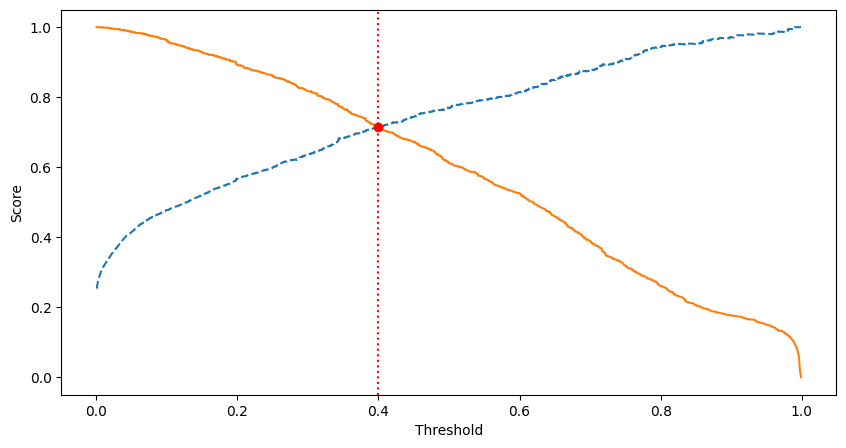

In [138]:

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_prop)

# Find the intersection point (closest where precision and recall are equal)
intersection_idx = np.argmin(np.abs(precision - recall))
intersection_threshold = thresholds[intersection_idx]
intersection_value = precision[intersection_idx]  # Same as recall at this point

# Plot precision and recall against thresholds
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label="Precision", linestyle='--')
plt.plot(thresholds, recall[:-1], label="Recall", linestyle='-')

# Add vertical and horizontal lines at the intersection
plt.axvline(intersection_threshold, color='red', linestyle=':', label="Intersection Threshold")
#plt.axhline(intersection_value, color='blue', linestyle=':', label="Intersection Value")

# Mark the intersection point
plt.scatter([intersection_threshold], [intersection_value], color='red', zorder=5)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt